## HEXAGONAL GRID GENERATION AND RASTER ZONAL STATISTICS 

#### The objective of this Notebook is to generate hexagonal tesselations that aggregate pixel values (by mean or median) of any Raster. It has been created using mainly rasterio, geopandas, and rasterstats python packages. The final output of the notebook, is a .GeoJSON with hexagonal geometries.

#### In the folder where this notebook is hosted, you will find the Area of Interest (AOI) GeoJSON and a Landsat 8 Raster image for testing.


#### 1. Import Required Packages

In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import h3
from shapely.geometry import Polygon
from rasterstats import zonal_stats
import pandas as pd

#### 2. Define Input Raster and Area of Interest (.geojson)

In [2]:
RASTER = r"C:\Users\fcam_\OneDrive - Universidad de los Andes\Copernicus_Master_Courses\Summer_Semester_2023\SOFTWARE_DEVELOPMENT\PLUS_softwaredev_2023_Felipe_Camacho\A3_Hexagonal_Grid\Landsat8_2018-08-01.tif"
AOI = gpd.read_file(r"C:\Users\fcam_\OneDrive - Universidad de los Andes\Copernicus_Master_Courses\Summer_Semester_2023\SOFTWARE_DEVELOPMENT\PLUS_softwaredev_2023_Felipe_Camacho\A3_Hexagonal_Grid\AOI.geojson")

#### 3. Open and Display the Raster

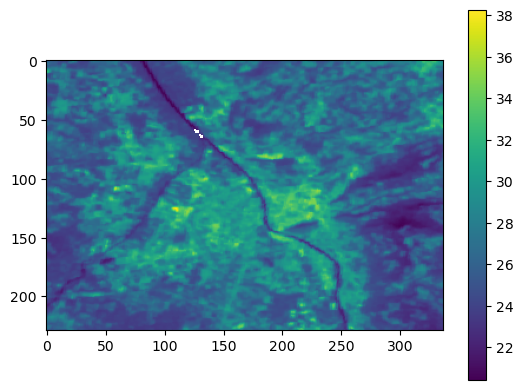

In [3]:
# Open the input raster file
with rasterio.open(RASTER) as src:
    # Read the raster data as a numpy array
    raster_data = src.read(1)
    # Get the spatial transformation information
    transform = src.transform
    # Get the raster extent
    extent = src.bounds
    
# Display the raster
plt.imshow(raster_data, cmap='viridis')
plt.colorbar()
plt.show()   

#### 4. Generate Hexagons withing the Area of Interest

In [4]:
# Generate hexagons within the AOI using H3 library
hexagons = h3.polyfill(AOI.geometry[0].__geo_interface__, 10, geo_json_conformant=True)

# Define a lambda function to convert H3 hexagon IDs to Shapely Polygon objects
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

print(polygonise)

# Create a GeoSeries of polygons from the hexagons, with hexagon IDs as index
hexagons_geoseries = gpd.GeoSeries(list(map(polygonise, hexagons)), index=hexagons, crs="EPSG:4326")

<function <lambda> at 0x0000029427CBC0D0>


#### 5. Visualize Hexagons


Text(0.5, 1.0, '17035 Hexagons')

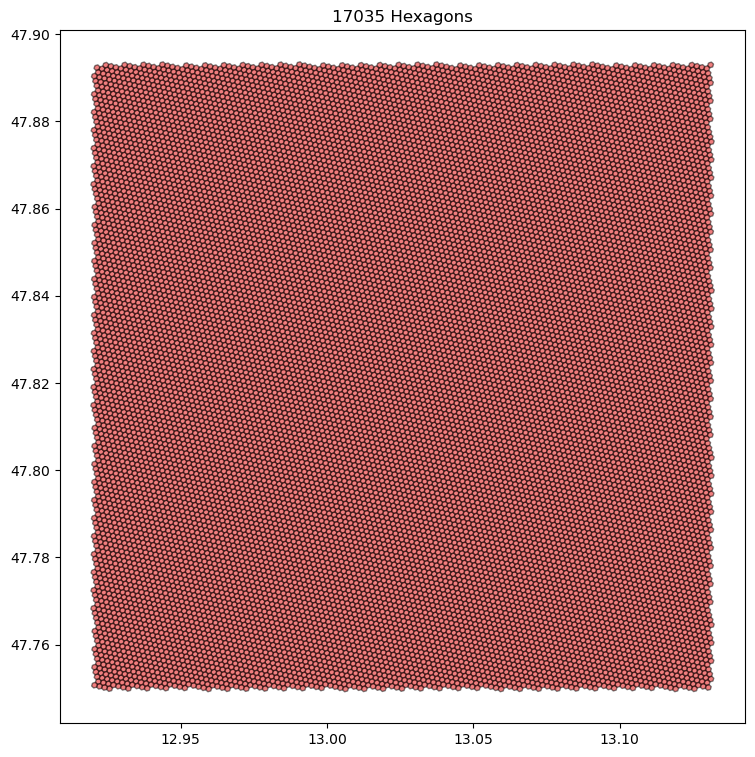

In [5]:
ax = hexagons_geoseries.plot(alpha=0.5, color="xkcd:red",edgecolor = "black", figsize=(9, 9))
ax.set_title(f"{hexagons_geoseries.shape[0]} Hexagons")

#### 6. Calculate Zonal Statistics

In [6]:
# Calculate zonal statistics for the raster within each polygon in hexagons_geoseries
statistics = zonal_stats(hexagons_geoseries, RASTER, stats="mean min max median")

# Convert the statistics to a pandas DataFrame
statistics = pd.DataFrame(statistics)

# Reset the index of hexagons_geoseries, dropping the existing index
hexagons_geoseries = hexagons_geoseries.reset_index(drop=True)

c:\Users\fcam_\anaconda3\envs\sentinel3_max\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


#### 7. Join Statistics and Hexagons

In [7]:
# Concatenate hexagons_geoseries and statistics along the columns axis
hexagons_statistics = pd.concat([hexagons_geoseries, statistics], axis=1)

# Extract the first column as the geometry
geometry = hexagons_statistics[0]

# Create a GeoDataFrame from hexagons_statistics with the specified CRS and using the extracted geometry column
hexagons_statistics_gdf = gpd.GeoDataFrame(hexagons_statistics, crs="EPSG:4326", geometry=geometry)

# Print the hexagons_statistics_gdf GeoDataFrame
print(hexagons_statistics_gdf)




                                                       0        min  \
0      POLYGON ((12.99937 47.81752, 12.99908 47.81688...  28.420437   
1      POLYGON ((12.97412 47.82454, 12.97383 47.82390...  25.282619   
2      POLYGON ((13.11676 47.79717, 13.11646 47.79653...  23.750545   
3      POLYGON ((13.10559 47.79685, 13.10530 47.79620...  22.585049   
4      POLYGON ((12.92155 47.84819, 12.92126 47.84754...  25.891323   
...                                                  ...        ...   
17030  POLYGON ((13.02842 47.76226, 13.02813 47.76161...  25.836971   
17031  POLYGON ((12.98697 47.77802, 12.98668 47.77738...  28.852200   
17032  POLYGON ((12.93150 47.80940, 12.93121 47.80875...  25.280270   
17033  POLYGON ((13.02638 47.81436, 13.02609 47.81372...  30.972530   
17034  POLYGON ((12.92170 47.76743, 12.92140 47.76678...  24.019711   

             max       mean     median  \
0      29.631008  28.914730  28.803738   
1      26.139126  25.542423  25.373974   
2      24.398342  24.

#### 8. Display Polygons as Choropleth map (with "mean" values)

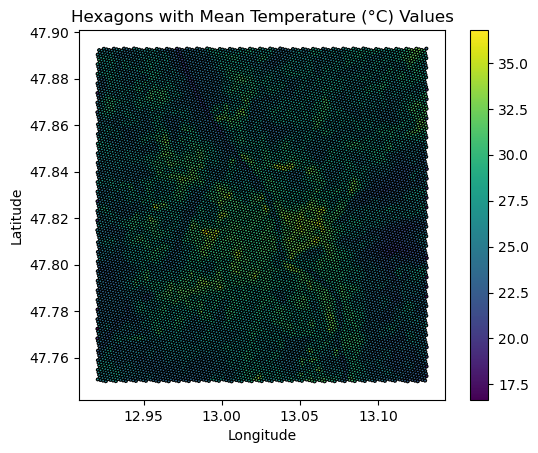

In [8]:
# Plot the hexagons with colors based on the 'mean' column
hexagons_statistics_gdf.plot(column='mean', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True)

# Set plot title and axis labels
plt.title('Hexagons with Mean Temperature (°C) Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

#### 9. Export Geodata Frame as GeoJson



In [9]:
# Drop the '0' column which contains the geometry as string.
hexagons_statistics_gdf = hexagons_statistics_gdf.drop(0, axis=1)  

# Export as GeoJSON
hexagons_statistics_gdf.to_file('Hexagonal_Grid_Salzburg.geojson', driver='GeoJSON')  


#### Created by: Felipe Camacho H based on the following documentation:

#### https://pypi.org/project/rasterstats/

#### https://pythonhosted.org/rasterstats/manual.html

#### https://github.com/stepankuzmin/h3-polyfill